In [2]:
import os
from thermof.read import read_log, read_thermo
import numpy as np
from wham2d import *
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
thermo_headers = 'Step Temp Press TotEng E_pair E_mol Fmax Fnorm c_C1[1] c_C1[2] c_C1[3]'
thermo_keys = ['step', 'temp', 'press', 'etotal', 'epair', 'emol', 'fmax', 'fnorm', 'x', 'y', 'z']

In [4]:
scandir = 'data/scan2'
scanlist = [os.path.join(scandir, i) for i in os.listdir(scandir)]
whamdir = os.path.abspath('wham')

### Write 2D WHAM time series files

In [5]:
start_pos = {}
for simdir in scanlist:
    logfile = os.path.join(simdir, 'log.HtBDC_Cu110')
    try:
        _, xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        thermo_data = read_log(logfile, headers=thermo_headers)
        thermo = read_thermo(thermo_data, headers=thermo_keys)[0]
        # Write time series files
        timeseriesfile = os.path.join(whamdir, 'data', '%i-%i-2d.dat' % (xi ,yi))
        time = timesteps_to_time(thermo['step'], dt=1, conversion=1e-3)  # femtosecond -> picosecond
        write_timeseries_file(timeseriesfile, time, thermo['x'], thermo['y'])
        for drx in ['x', 'y']:
            # Record starting position (min energy pos)
            start_pos['%i-%i-%s' % (xi ,yi, drx)] = thermo[drx][0]
    except Exception as e:
        print(e, logfile)

### Write 2D WHAM input files

In [6]:
nx, ny = 19, 14
tsfiles, mins_x, mins_y = [], [], []
for ypos in range(ny):
    for xpos in range(nx):
        tsfiles.append(os.path.join(whamdir, 'data', '%i-%i-2d.dat' % (xpos ,ypos)))
        mins_x.append(start_pos['%i-%i-x' % (xpos ,ypos)])
        mins_y.append(start_pos['%i-%i-y' % (xpos ,ypos)])

datafile = os.path.join(whamdir, 'wham-2d', 'wham-2d.in')
spring_k = [5.0] * len(tsfiles)
write_data_file(datafile, tsfiles, mins_x, mins_y, spring_k, spring_k)

### Run 2D WHAM

In [7]:
hist_min_x, hist_max_x = 21.582, 25.182
hist_min_y, hist_max_y = 22.8912, 25.4912
bin_size = 0.1
num_bins_x = int(np.ceil((hist_max_x - hist_min_x) / bin_size))
num_bins_y = int(np.ceil((hist_max_y - hist_min_y) / bin_size))
Px, Py = 'Px=0', 'Py=0'
tolerance = 1e-5
temperature = 200
numpad = 0
use_mask = 0
wham_exec = '/home/kutay/Documents/Research/Software/wham/wham-2d/wham-2d'
outfile = os.path.join(whamdir, 'wham-2d', 'wham-2d.out')
wham_args = [wham_exec, Px, hist_min_x, hist_max_x, num_bins_x, Py, hist_min_y, hist_max_y, num_bins_y, tolerance, temperature, numpad, datafile, outfile, use_mask]

In [8]:
data = run_wham(wham_args)

In [44]:
xbins = [round(i, 4) for i in np.arange(min(data['x']), max(data['x']) + bin_size * 0.5, bin_size)]
ybins = [round(i, 4) for i in np.arange(min(data['y']), max(data['y']) + bin_size * 0.5, bin_size)]
matrixdata = np.zeros((len(xbins), len(ybins)))

In [46]:
for idx, free in enumerate(data['free']):
    x_idx = xbins.index(data['x'][idx])
    y_idx = ybins.index(data['y'][idx])
    matrixdata[x_idx][y_idx] = free

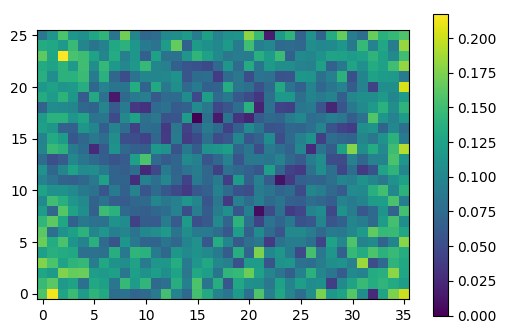

In [48]:
plt.imshow(matrixdata.T, origin='lower')
plt.colorbar()

In [105]:
Ea = 1
RT = np.arange(1, 100, 1)
arr = 1 * np.exp(-Ea / RT)
arr1 = 0.95 * np.exp(-Ea / RT)
arr2 = 0.9 * np.exp(-Ea / RT)

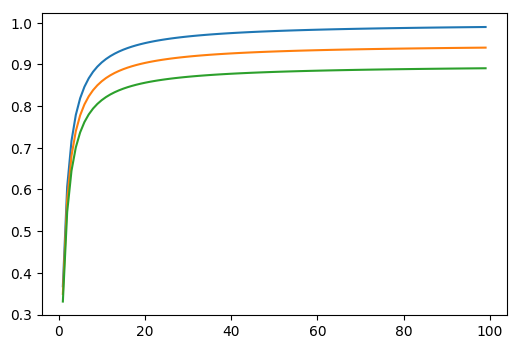

In [106]:
plt.plot(RT, arr)
plt.plot(RT, arr1)
plt.plot(RT, arr2)

In [115]:
Ea = 1
RT = np.arange(2, 100, 1)
arr = 1 * np.exp(-1 / RT)
arr1 = 1 * np.exp(-0.5 / RT)
arr2 = 1 * np.exp(-0.25 / RT)

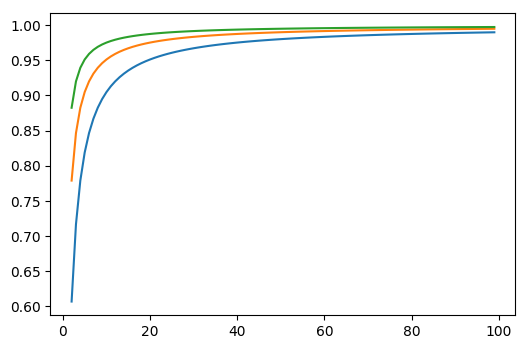

In [116]:
plt.plot(RT, arr)
plt.plot(RT, arr1)
plt.plot(RT, arr2)

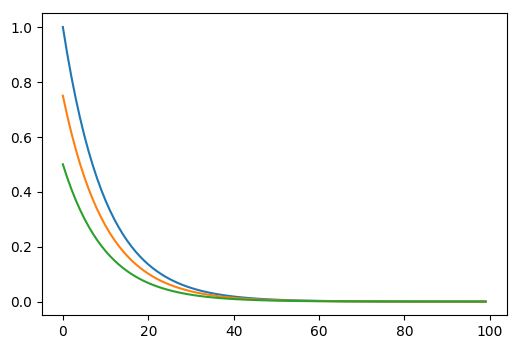

In [83]:
plt.plot(Ea, arr)
plt.plot(Ea, arr1)
plt.plot(Ea, arr2)

In [93]:
whamdata = []
for ypos in range(ny):
    datafile = os.path.join(whamdir, 'wham-1d', '%i-%s.in' % (ypos, drx))
    outfile = os.path.join(whamdir, 'wham-1d', 'out', '%i-%s.out' % (ypos, drx))
    wham_args = [wham_exec, hist_min, hist_max, num_bins, tolerance, temperature, numpad, datafile, outfile]
    data = run_wham(wham_args)
    whamdata.append(data)

In [101]:
def subplot(plot_fun, plot_data, plot_args={}, nrow=1, width=3, height=3, dpi=200, wspace=0.25, hspace=0.5, save=None, title=None):
    n_plots = len(plot_data)
    ncol = np.ceil(n_plots / nrow)
    figsize = (ncol * width, nrow * height)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    for idx, data in enumerate(plot_data, start=1):
        plot_args['ax'] = fig.add_subplot(nrow, ncol, idx)
        plot_fun(data, **plot_args)
        if title is not None:
            plt.title(title[idx - 1])
    if save is not None:
        plt.savefig(save, dpi=dpi, transparent=True, bbox_inches='tight')
        
def scatter_plot(data, ax):
    ax.plot(data['coor'], data['free'], '-o')
    plt.ylim(0, 0.15)

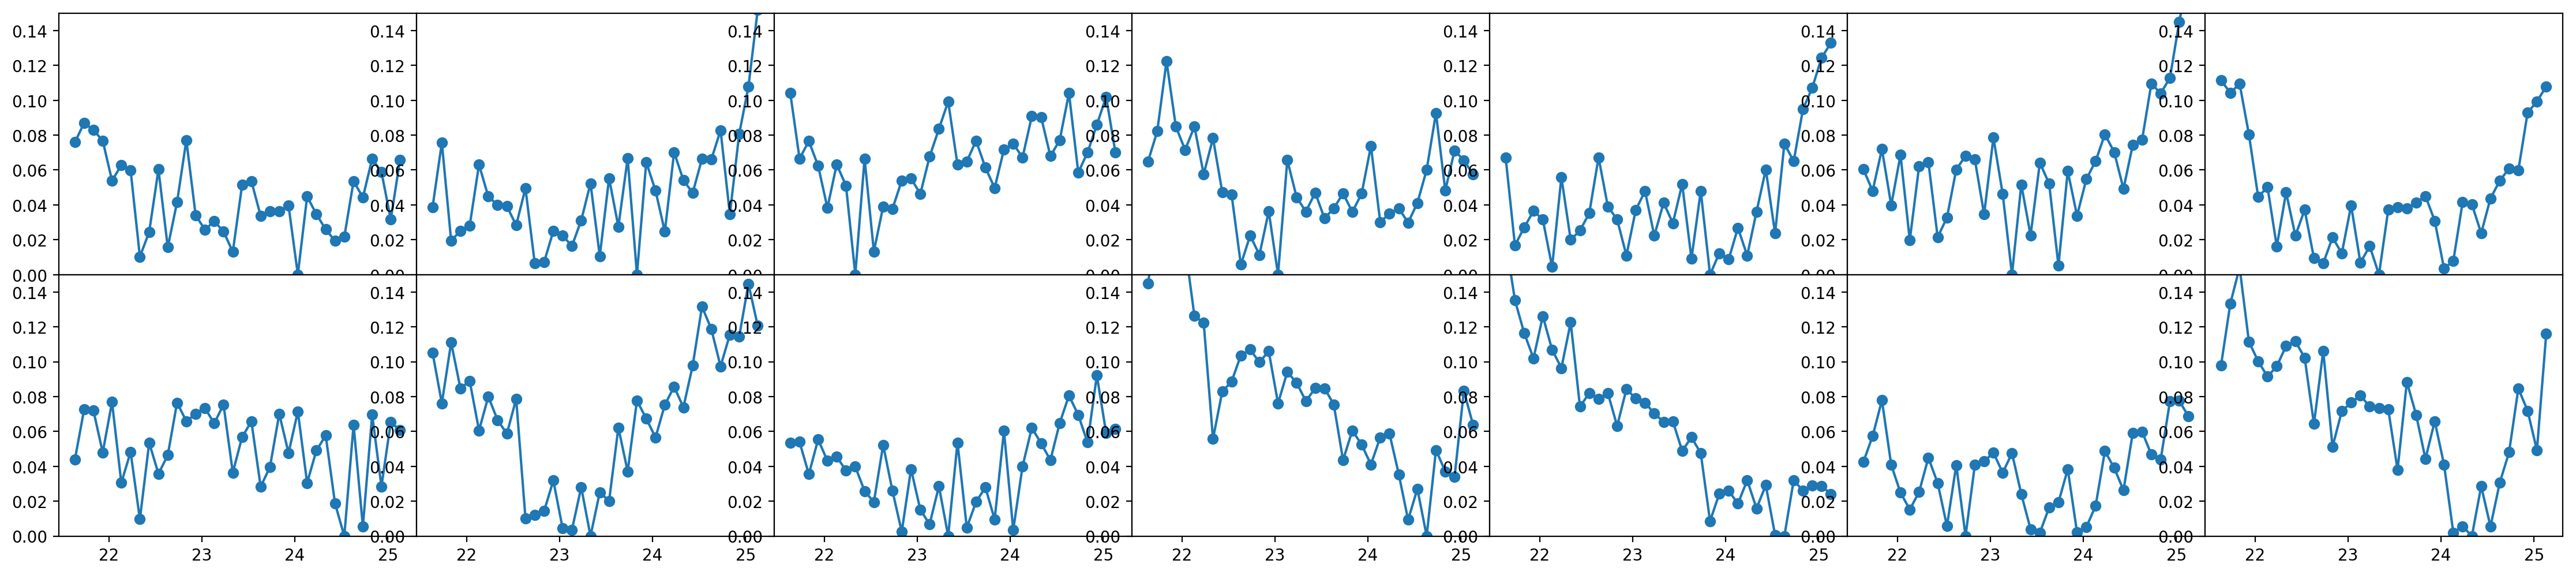

In [103]:
subplot(scatter_plot, whamdata, wspace=0, hspace=0, nrow=2, width=4)

In [108]:
matrixdata = np.zeros((len(whamdata[0]['coor']), 14))
for yi, data in enumerate(whamdata):
    for xi, free in enumerate(data['free']):
        matrixdata[xi][yi] = free

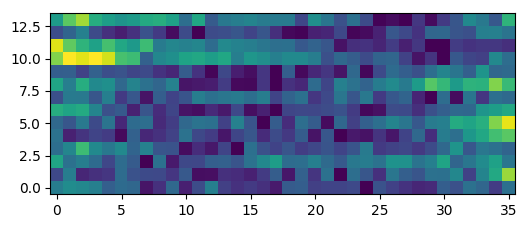

In [113]:
plt.imshow(matrixdata.T, origin='lower')
# plt.colorbar()

In [107]:
len(whamdata[0]['coor'])

36

In [ ]:
for ypos in range(ny):
    tsfiles, mins = [], []
    for xpos in range(nx):
        tsfiles.append(os.path.join(whamdir, 'data', '%i-%i-%s.dat' % (xpos ,ypos, drx)))
        mins.append(start_pos['%i-%i-%s' % (xpos ,ypos, drx)])
    datafile = os.path.join(whamdir, 'wham-1d', '%i-%s.in' % (ypos, drx))
    spring_k = [5.0] * len(tsfiles)
    write_data_file(datafile, tsfiles, mins, spring_k)